In [1]:
from stackrecommender import Recommender
from stacksite import StackSite
import numpy as np
import pandas as pd
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import logistic
import sklearn.metrics
import warnings
import sys, time
try:
    import cPickle as pkl
except:
    import pickle as pkl
import bz2
from tqdm import *
import sklearn.metrics
#import numbapro
import pathos.multiprocessing as pmp
import datetime

warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
site_name = 'worldbuilding.stackexchange.com'
site = StackSite(site_name)
site.load()
df_dict = site.df_dict()

Dataframes successfully loaded.


In [28]:

len(answers_df)
len(questions_df)
len(users_df)

2258

In [3]:
users_df = site.df('users').drop('-999')
answers_df = site.df('answers')[site.df('answers').user_id != '-999']
questions_df = site.df('questions').copy()
df_dict['users'] = users_df
df_dict['answers'] = answers_df
df_dict['questions'] = questions_df

In [6]:
rc = Recommender(site_name, df_dict = df_dict)
rc.load('full')

Training...
 ...created the dictionary.
 ...vectorized the corpus.
 ...training the LDA model on 100 topics in 1 passes and 1000 iterations.
 ...trained the LDA model.
Done training!


In [9]:
rc.save('full')

Saving the model...
 ...saved the dictionary.
 ...saved the corpus.
 ...saved the LDA model.
 ...saved the LDA vectors.


In [10]:
df_names = ['answers', 'comments']
df_lengths = {name:len(df_dict[name]) for name in df_names}
print df_lengths

# generate the train/test split index arrays
n_folds = 5
folds = {name:KFold(df_lengths[name], n_folds=n_folds) for name in df_names}

# generate the train/test dataframes
train_dfs = {name:[] for name in df_names}
test_dfs = {name:[] for name in df_names}
for name in df_names:
    for train, test in folds[name]:
        train_dfs[name].append(df_dict[name].ix[train])
        test_dfs[name].append(df_dict[name].ix[test])
        
for j in range(1):
    print "train/test split:", len(train_dfs['answers'][j]), len(test_dfs['answers'][j])
    
# split questions_df according to the train/test split of answers_df (pain in the ass,
# but I want to honestly retrain the LDA model each fold)
train_dfs['questions'] = range(n_folds)
test_dfs['questions'] = range(n_folds)
questions_df = site.df('questions').copy()
questions_df['full_question'] = questions_df.title + " " + questions_df.question

for j in range(n_folds):
    train_qids = train_dfs['answers'][j].parent_id.unique().tolist() # indices are already unique
    test_qids = test_dfs['answers'][j].parent_id.unique().tolist() # but df.index is mutable and not hashable
    train_dfs['questions'][j] = questions_df.ix[train_qids]
    test_dfs['questions'][j] = questions_df.ix[test_qids]
    
# pack the training sets into dictionaries of dataframes for the recommender
df_names.append('questions')
train_df_dicts = range(n_folds)
for j in range(n_folds):
    train_df_dicts[j] = {name:train_dfs[name][j] for name in df_names}
    train_df_dicts[j]['tags'] = site.df('tags')
    train_df_dicts[j]['users'] = site.df('users')
    
tags_df = site.df('tags').copy()

{'comments': 20755, 'answers': 6342}
train/test split: 5073 1269


In [11]:
class ZeroClassifier(object):
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return
    
    def predict(self, X):
        return 0.
    
    def predict_proba(self, X):
        return np.array([[1.,0.]])

In [12]:
class DotClassifier(object):
    
    def __init__(self, threshold = 0.5, k = 1.):
        self.vec = 0.
        self.threshold = threshold
        self.k = k
        return 
    
    def __str__(self):
        return "DotClassifier(threshold="+str(self.threshold)+", k="+str(self.k)+")"
    
    def sigmoid(self, a):
        return (1. / (1. + np.exp( -self.k*a )))
    
    def fit(self, X, y):
        self.vec = np.sum(X, axis=0)
        return
    
    def predict(self, X):
        x = X
        return self.sigmoid(np.dot(self.vec,x)) > self.threshold
    
    def predict_proba(self, X):
        x = X
        a = self.sigmoid(np.dot(self.vec,x))
        return np.array([[1-a, a]])

In [22]:
# parameters for the run
cutoff = 2 # min score of a 'good' answer
threshold = 0.4 # threshold for positive classification
num_topics = 100
iterations = 1000
passes = 1
tfidf = False
model_clf = LogisticRegression(fit_intercept = False, penalty = 'l2')
score_weight = 1
# model_clf = RandomForestClassifier() 
# model_clf = DotClassifier(threshold = threshold, k=1000)

In [24]:
results = [0] * n_folds
n_folds_to_train = 5

# train the LDA model on the fold?
train_LDA = False

# set the number of workers
multiprocessing = True
n_procs = 7

verbose = True
def printv(a):
    if verbose:
        print a
        sys.stdout.flush()
    return

def make_poolmap(multiprocessing=True, n_procs=7):
    if multiprocessing:
        pool = pmp.Pool(n_procs)
        return pool.map
    else:
        return map

start_time = time.time()
for i in range(n_folds_to_train):
    
    printv("\nFold %d/%d" % (i+1, n_folds))
    
    fold_start_time = time.time()
    if train_LDA: 
        rc = Recommender(site_name, df_dict = train_df_dicts[i])
    rc.train(num_topics = num_topics, iterations = iterations, 
             passes = passes, multicore = True, tfidf = tfidf,
             train_LDA = train_LDA)

    #reset the classifiers and setup new user groups
    users_df['clf'] = ZeroClassifier()
    users_df['X'] = None
    users_df['y'] = None
    user_gps = train_dfs['answers'][i].groupby('user_id')
    users_df.clf.ix[user_gps.groups.keys()] = [model_clf for _ in xrange(len(user_gps.groups.keys()))]
    
    # do logistic regression for each user
    printv("Fitting...")
    
    printv(" ...creating training vectors.")
    
    def make_X(user):
        questions = questions_df.full_question.ix[user_gps.get_group(user).parent_id]
        LDAvec = rc.post2LDAvec(questions)
        vec = rc.LDAvec2ndarray(LDAvec)
        scores = user_gps.get_group(user).score[:,np.newaxis] - cutoff
        X = np.vstack([np.zeros(rc.LDAmodel.num_topics),
                                np.ones(rc.LDAmodel.num_topics) / rc.LDAmodel.num_topics,
                                vec*(score_weight*scores)])
        return X

    def make_y(user):
        y = np.concatenate([[0,1],(user_gps.get_group(user).score >= cutoff).values])
        return y

    my_map = make_poolmap(multiprocessing=multiprocessing, n_procs=n_procs)
    users_df['X'].ix[user_gps.groups.keys()] = my_map(make_X, user_gps.groups.keys())     
    
    my_map = make_poolmap(multiprocessing=multiprocessing, n_procs=n_procs)
    users_df['y'].ix[user_gps.groups.keys()] = my_map(make_y, user_gps.groups.keys())
    
    printv(" ...done creating training vectors.")
    printv(" ...fitting the classifiers.")
    
    #my_map = make_poolmap(multiprocessing=multiprocessing, n_procs=n_procs)
    def fita(user_id):
        users_df.clf.ix[user_id].fit(users_df.X.ix[user_id],users_df.y.ix[user_id])
        return
    map(fita, user_gps.groups.keys())
    
    printv(" ...done fitting.")
    printv("Testing...")

    # build the test LDA vectors
    test_dfs['questions'][i]['feature_vec'] = test_dfs['questions'][i].title + " " + test_dfs['questions'][i].question
    test_dfs['questions'][i]['feature_vec'] = test_dfs['questions'][i]['feature_vec'].apply(rc.post2LDAvec)
    test_dfs['questions'][i]['feature_vec'] = test_dfs['questions'][i]['feature_vec'].apply(rc.LDAvec2ndarray)
    printv(" ... built LDA vectors.")

    # compute the results of the fold
    results[i] = pd.DataFrame()
    results[i]['actual'] = test_dfs['answers'][i].score.values >= cutoff
    results[i]['predicted'] = 0.
    results[i]['proba'] = 0.
    printv(" ... recording results.")

    my_map = make_poolmap(multiprocessing=multiprocessing, n_procs=n_procs)
    def predicta(a):
        return a[0].predict_proba(a[1])[0][1]
    results[i]['proba'] = my_map(predicta, 
                                zip(users_df.clf.ix[test_dfs['answers'][i].user_id], 
                                test_dfs['questions'][i].feature_vec.ix[test_dfs['answers'][i].parent_id]))
    
    my_map = make_poolmap(multiprocessing=multiprocessing, n_procs=n_procs)
    def thresha(a):
        return (a > threshold)
    results[i]['predicted'] = my_map(thresha, results[i]['proba'])
    
    fold_end_time = time.time()
    printv("Fold done: %s" % str(datetime.timedelta(seconds=(fold_end_time-fold_start_time))))
    sys.stdout.flush()

full_results = pd.DataFrame(data={'actual':np.concatenate([x.actual for x in results[:n_folds_to_train]]), 
                                  'predicted':np.concatenate([x.predicted for x in results[:n_folds_to_train]]),
                                  'proba':np.concatenate([x.proba for x in results[:n_folds_to_train]])})

print "\nnumber of folds trained %d/%d" % (n_folds_to_train, n_folds)
print "cutoff =", cutoff
print "num_topics =", num_topics
print model_clf
print "Precision: %.2f" % (sklearn.metrics.precision_score(full_results.actual,full_results.predicted))
print "Recall: %.2f" % (sklearn.metrics.recall_score(full_results.actual,full_results.predicted))
print "ROC-AUC: %.2f" % (sklearn.metrics.roc_auc_score(full_results.actual, full_results.proba))
end_time = time.time()
print "Time: ", str(datetime.timedelta(seconds=(end_time-start_time)))


Fold 1/5
Training...
Done training!
Fitting...
 ...creating training vectors.
 ...done creating training vectors.
 ...fitting the classifiers.
 ...done fitting.
Testing...
 ... built LDA vectors.
 ... recording results.
Fold done: 0:00:27.928145

Fold 2/5
Training...
Done training!
Fitting...
 ...creating training vectors.
 ...done creating training vectors.
 ...fitting the classifiers.
 ...done fitting.
Testing...
 ... built LDA vectors.
 ... recording results.
Fold done: 0:00:30.271209

Fold 3/5
Training...
Done training!
Fitting...
 ...creating training vectors.
 ...done creating training vectors.
 ...fitting the classifiers.
 ...done fitting.
Testing...
 ... built LDA vectors.
 ... recording results.
Fold done: 0:00:26.213243

Fold 4/5
Training...
Done training!
Fitting...
 ...creating training vectors.
 ...done creating training vectors.
 ...fitting the classifiers.
 ...done fitting.
Testing...
 ... built LDA vectors.
 ... recording results.
Fold done: 0:00:25.019905

Fold 5/5
Tr

### worldbuiding: Results

    number of folds trained 5/5
    cutoff = 2
    num_topics = 100
    LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
              intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)
    Precision: 0.69
    Recall: 0.81
    ROC-AUC: 0.54
    Time:  0:02:14.792568

    number of folds trained 5/5
    cutoff = 3
    num_topics = 100
    DotClassifier(threshold=0.5, k=1000)
    Precision: 0.51
    Recall: 0.19
    ROC-AUC: 0.49
    
    number of folds trained 5/5
    cutoff = 5
    num_topics = 100
    DotClassifier(threshold=0.4, k=1000)
    Precision: 0.30
    Recall: 0.18
    ROC-AUC: 0.49
    Time:  0:01:57.421682

In [17]:
answers_df.groupby('user_id').count().mean()

parent_id    5.151909
score        5.151909
answer       5.151909
dtype: float64

### datascience: Results

    number of folds trained 5/5
    cutoff = 3
    num_topics = 100
    DotClassifier(threshold=0.5, k=1000)
    Precision: 0.54
    Recall: 0.68
    ROC-AUC: 0.59

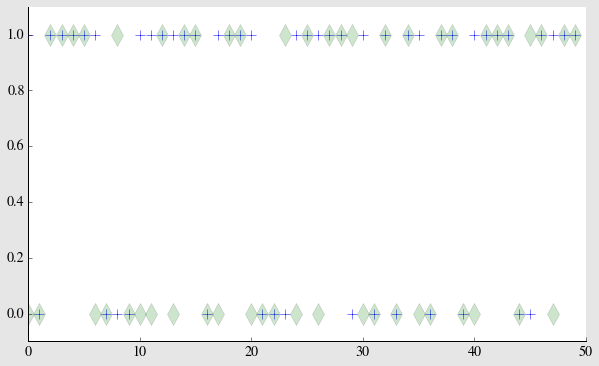

In [182]:
# a quick look at the results
plt.plot(full_results.actual[50:100], 'b+', markersize=10)
#plt.plot(full_results.predicted[50:100], 'ro', alpha = 0.5)
plt.plot(full_results.proba[50:100], 'gd', markersize=15, alpha = 0.2)
plt.ylim(-0.1,1.1)
remove_border()

##Scratch 